### Import Modules

In [1]:
from luma.preprocessing.scaler import StandardScaler
from luma.model_selection.split import TrainTestSplit
from luma.neural.multi_layer import MLPClassifier
from luma.visual.evaluation import ConfusionMatrix, ROCCurve, PrecisionRecallCurve

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST Dataset

In [2]:
X, y = fetch_openml('mnist_784', version=1, as_frame=False, return_X_y=True)
X.shape, len(np.unique(y))

/Users/chanlee/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


((70000, 784), 10)

### Split Dataset

In [3]:
X_train, X_test, y_train, y_test = TrainTestSplit(X, y.astype(int), 
                                                  test_size=0.2, 
                                                  random_state=42).get
X_train.shape, X_test.shape

((56000, 784), (14000, 784))

### Standardize Through `StandardScaler`

In [4]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

### Construct MLP

In [5]:
mlp = MLPClassifier(input_size=784,
                    hidden_sizes=128,
                    output_size=10,
                    max_epoch=1000,
                    learning_rate=1e-5,
                    lambda_=0.01,
                    dropout_rate=0.05,
                    activation='relu',
                    verbose=50)

### Train MLP

In [6]:
mlp.fit(X_train_std, y_train)
mlp.score(X_test_std, y_test)

[MLPClassifier] Epoch 0, Loss: 2.303604262984684
[MLPClassifier] Epoch 50, Loss: 0.2606702647666447
[MLPClassifier] Epoch 100, Loss: 0.19407239894880063
[MLPClassifier] Epoch 150, Loss: 0.15794643453507295
[MLPClassifier] Epoch 200, Loss: 0.13467669310660701
[MLPClassifier] Epoch 250, Loss: 0.11623951349414803
[MLPClassifier] Epoch 300, Loss: 0.10322330307000782
[MLPClassifier] Epoch 350, Loss: 0.09300160316609234
[MLPClassifier] Epoch 400, Loss: 0.08355726013321457
[MLPClassifier] Epoch 450, Loss: 0.07769183200887742
[MLPClassifier] Epoch 500, Loss: 0.07016529453290743
[MLPClassifier] Epoch 550, Loss: 0.06601742150669494
[MLPClassifier] Epoch 600, Loss: 0.061357056198030384
[MLPClassifier] Epoch 650, Loss: 0.0567581933343201
[MLPClassifier] Epoch 700, Loss: 0.05523374541465102
[MLPClassifier] Epoch 750, Loss: 0.050975375587188225
[MLPClassifier] Epoch 800, Loss: 0.048807523655764254
[MLPClassifier] Epoch 850, Loss: 0.047306548084005515
[MLPClassifier] Epoch 900, Loss: 0.04571841461863

0.9696428571428571

### Print MLP Configuration

In [9]:
mlp.dump()

+----------------------------------------------------------------------+
|                          MLP Configuration                           |
|                           Input Size : 784                           |
|   Layer 1 (Hidden) : 784 -> 128, Parameters: 100352 + 128 = 100480   |
|      Layer 2 (Output) : 128 -> 10, Parameters: 1280 + 10 = 1290      |
|                       Total Parameters: 101770                       |
|                      Activation Function: ReLU                       |
+----------------------------------------------------------------------+


### Plot Losses

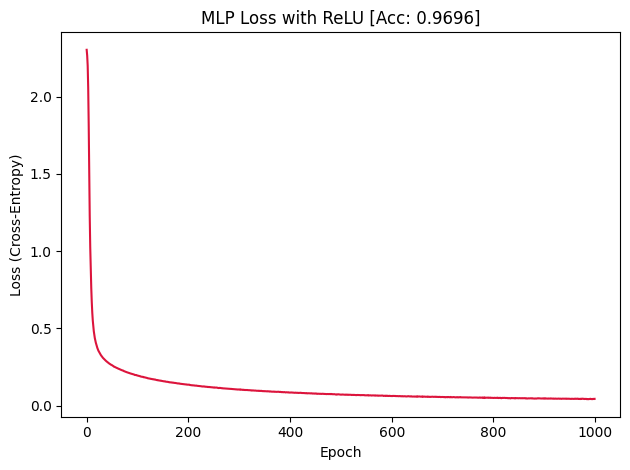

In [10]:
plt.plot(range(mlp.max_epoch), mlp.losses_, c='crimson')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.title(f'MLP Loss with {type(mlp.act_).__name__} [Acc: {mlp.score(X_test_std, y_test):.4f}]')
plt.tight_layout()
plt.show()

### Visualize Weights

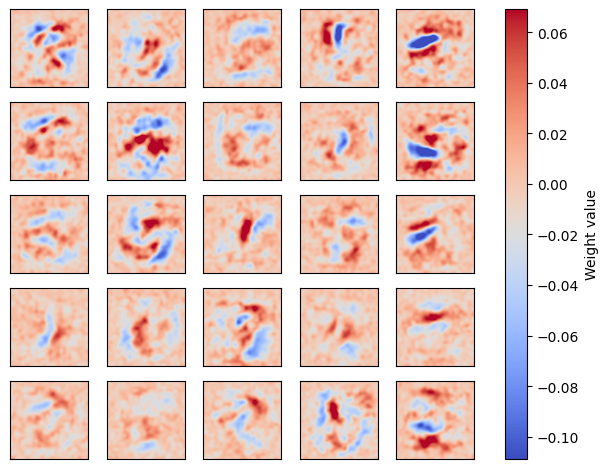

In [72]:
fig, axes = plt.subplots(5, 5)
global_vmin = 0.4 * mlp.weights[0].min()
global_vmax = 0.4 * mlp.weights[0].max()

for coef, ax in zip(mlp.weights[0].T, axes.ravel()):
    im = ax.matshow(coef.reshape(28, 28), 
                    cmap='coolwarm', 
                    vmin=global_vmin, 
                    vmax=global_vmax, 
                    interpolation='bicubic')
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Weight value')
plt.show()

### ROC-AUC Curve

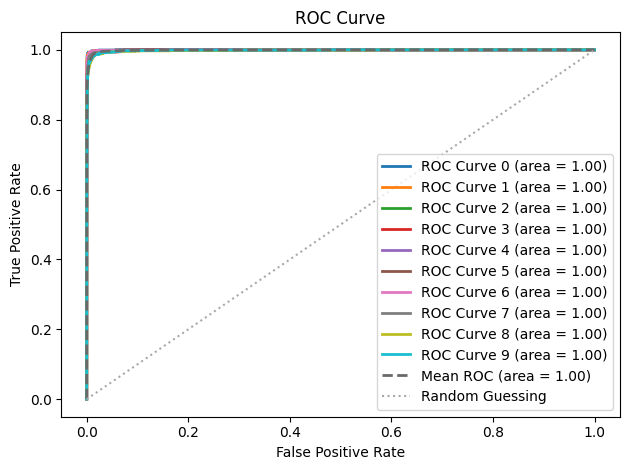

<Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
roc = ROCCurve(y_test, mlp.predict_proba(X_test_std))
roc.plot(show=True)

### PR Curve

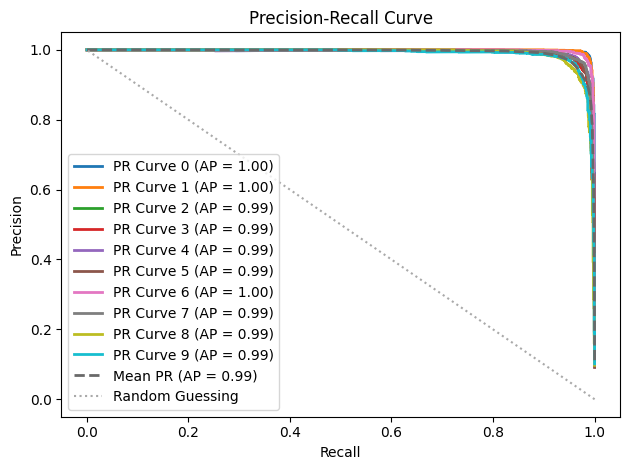

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

In [40]:
pr = PrecisionRecallCurve(y_test, mlp.predict_proba(X_test_std))
pr.plot(show=True)

### Confusion Matrix

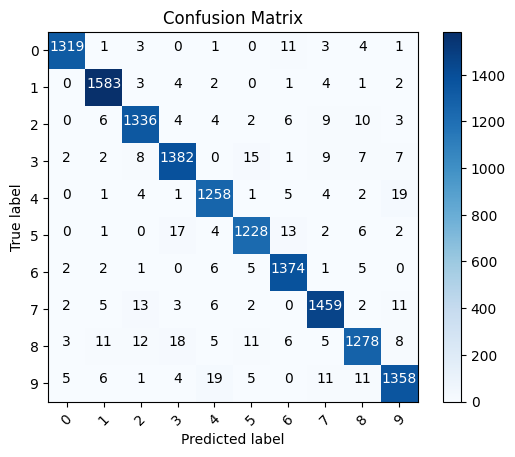

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [41]:
conf = ConfusionMatrix(y_test, mlp.predict(X_test_std))
conf.plot(show=True)

### Visualize Sample Data Predictions

In [42]:
def plot_images(images, y_true, y_pred, cmap=plt.cm.gray_r):
    fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(7, 7))
    fig.suptitle('Image Grid (True, Prediction)', fontsize=16)
    axes = axes.flatten()
    for img, ax, true, pred in zip(images, axes, y_true, y_pred):
        ax.imshow(img, cmap=cmap, interpolation='nearest')
        ax.set_title(f"{true}, {pred}, {true == pred}")
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

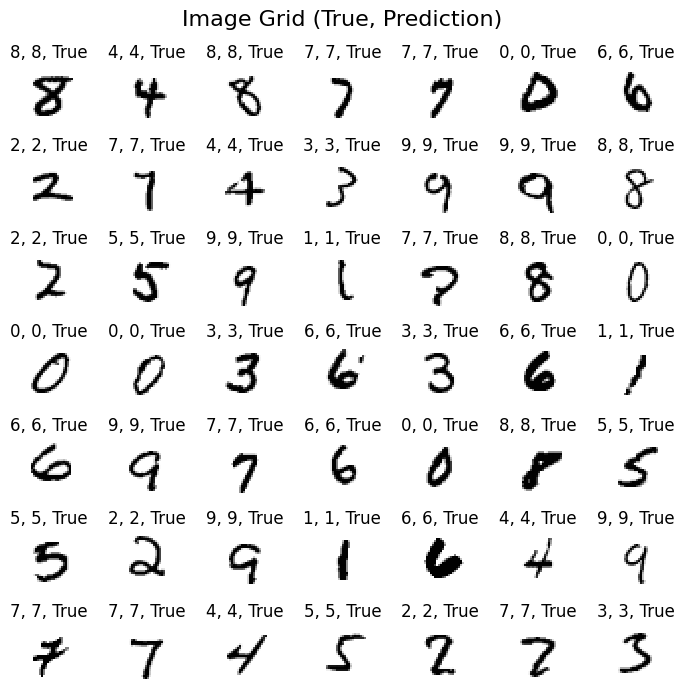

In [43]:
plot_images(X_test[:49].reshape(-1, 28, 28), y_test[:49], mlp.predict(X_test_std[:49]))